In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow_gan as tfgan
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 

import matplotlib.pyplot as plt

import sys

import numpy as np
import pandas as pd

import os

from PIL import Image

# Load Data
Loading from preprocessed numpy array

In [71]:
def load_data():
    # test, train split
    x_train = np.array(pd.read_csv("./data_stock/SP500_average.csv",).drop([0]).drop(columns=['Date']))
    return x_train
            

def merge_time_series(arr1, arr2) -> tf.float64 :
    t1 = tf.cast(arr1, 'float64') if tf.is_tensor(arr1) else tf.convert_to_tensor(arr1, dtype='float64')
    t2 = tf.cast(arr2, 'float64') if tf.is_tensor(arr2) else tf.convert_to_tensor(arr2, dtype='float64')
    if(len(t2.shape)==2):
        t2 = tf.expand_dims(t2, 1);
    return tf.concat([t1, t2 ], axis=1)

def split_time_series(t, arr) -> (np.array, np.array):
    a = []
    b = []
    for i in range(len(arr)-t):
        a.append(arr[i: i+t])
        b.append(arr[i+t])
    return (np.array(a), np.array(b))

(input, output) = split_time_series(5, load_data())
print(f'{output.shape}')
merged = merge_time_series(input, output)
print("input",input)
print("output", output)
print("merged",merged)

def batch_standardize(input):
    def standardize_fn(i) : 
        scaler = StandardScaler();
        scaler.fit(i)
        return (scaler.transform(i), scaler)
    return zip(*[ standardize_fn (i) for i in input])

# scalers require 2D arrays, so add artifically add a dimension when the input is 1D
def batch_scale(input, scalers):
    scale = lambda x,s : s.transform(x) if(len(x.shape)==2) else s.transform([x])[0]
    return list(map(scale, input, scalers))

def batch_inverse_scale(input, scalers):
    scale = lambda x,s : s.inverse_transform(x) if(len(x.shape)==2) else s.inverse_transform([x])[0]
    return list(map(scale, input, scalers))

    
                                

(466, 4)
input [[[4366.64 4411.01 4287.11 4356.45]
  [4356.32 4417.35 4222.62 4410.13]
  [4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]]

 [[4356.32 4417.35 4222.62 4410.13]
  [4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]
  [4632.24 4632.24 4568.7  4577.11]]

 [[4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]
  [4632.24 4632.24 4568.7  4577.11]
  [4637.99 4665.13 4614.75 4662.85]]

 ...

 [[2457.77 2571.42 2407.53 2475.56]
  [2344.44 2449.71 2344.44 2447.33]
  [2290.71 2300.73 2191.86 2237.4 ]
  [2431.94 2453.01 2295.56 2304.92]
  [2393.48 2466.97 2319.78 2409.39]]

 [[2344.44 2449.71 2344.44 2447.33]
  [2290.71 2300.73 2191.86 2237.4 ]
  [2431.94 2453.01 2295.56 2304.92]
  [2393.48 2466.97 2319.78 2409.39]
  [2436.5  2453.57 2280.52 2398.1 ]]

 [[2290.71 2300.73 2191.86 2237.4 ]
  [2431.94 2453.01 2295.56 2304.9

# Creating GAN

In [64]:
class LSTMGAN():
    def __init__(self, t, f, data):
        self.data = data
        self.time_series_len = t
        self.feature_len = f
        self.gen_shape = (self.time_series_len, self.feature_len)
        self.dis_shape = (self.time_series_len+1, self.feature_len)

        optimizer = Adam(0.0001, 0.4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        # Trains the generator to imitate input data
        self.generator.compile(loss='mean_squared_error',
            optimizer=optimizer)
        
        # The generator takes noise as input and generates song
        noise = Input(shape=self.gen_shape)
        gen_output = self.generator(noise)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(merge_time_series(noise, gen_output))

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(noise, valid)
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        

    def build_generator(self):

        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=self.gen_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(128)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(4))
        # model.summary()

        noise = Input(shape=self.gen_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Bidirectional(LSTM(128, activation = 'relu', return_sequences=True), input_shape=self.dis_shape))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(128, activation = 'relu')))
        model.add(Dense(1, activation = 'linear'))
        #model.summary()

        img = Input(shape=self.dis_shape)
        validity = model(img)

        return Model(img, validity)
    
    
    def train(self, epochs, batch_size=128, save_interval=50):
    

        # Load the dataset
        (X_train_input, X_train_output) = split_time_series(self.time_series_len, self.data)

        # normalize

        # Adversarial ground truths
        valid = np.ones(batch_size)
        fake = np.zeros(batch_size)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Select a random half of songs
            idx = np.random.randint(0, X_train_input.shape[0], batch_size)
            real_input= X_train_input[idx]
            real_output= X_train_output[idx]
            
           
            
            (real_input, scalers) = batch_standardize(real_input)
            real_output = batch_scale(real_output, scalers)
            
            # Sample noise and generate a batch of new prices
            noise = np.random.normal(0, 1, (batch_size,self.time_series_len,self.feature_len))
            gen_output = self.generator.predict(noise, batch_size = batch_size)
            real_series = merge_time_series(real_input,real_output)
            fake_series = merge_time_series(real_input,gen_output)
            print("input:\n", scalers[0].inverse_transform( real_input[0]))
            print("fake_output:\n", scalers[0].inverse_transform( [gen_output[0]])[0])
            print("real_output:\n", scalers[0].inverse_transform( [real_output[0]])[0])

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(real_series, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_series, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            # First training (wants generator to imitate real data)
            g_loss1 = self.generator.train_on_batch( np.array(real_input), np.array(real_output))
            
            # Second training (wants discriminator to mistake songs as real)
            g_loss2 = self.combined.train_on_batch(noise, valid)
            g_loss = 0.5 * np.add(g_loss1, g_loss2)



            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save model
            if epoch % save_interval == 0:
                self.generator.save("LSTM_generator.h5")

# Model Summary
I couldn't train the model on this online notebook so I trained it locally for 1000 epochs and uploaded the h5 file.

In [72]:
lstmgan = LSTMGAN(5, 4, load_data())
lstmgan.train(epochs=1000, batch_size=50, save_interval=100)

input:
 [[3111.56 3128.91 3090.41 3112.35]
 [3098.9  3130.94 3098.9  3122.87]
 [3064.78 3081.07 3051.64 3080.82]
 [3038.78 3062.18 3031.54 3055.73]
 [3025.17 3049.17 2998.61 3044.31]]
fake_output:
 [[3068.69779241 3089.55789047 3054.4615908  3083.07518185]]
real_output:
 [[3046.61 3068.67 3023.4  3029.73]]
0 [D loss: 5.967822, acc.: 50.00%] [G loss: 7.291785]
input:
 [[3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]
 [3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]]
fake_output:
 [[3508.62067368 3528.25810702 3495.31941574 3520.09242469]]
real_output:
 [[3449.97 3481.07 3444.15 3478.73]]
1 [D loss: 5.448864, acc.: 50.00%] [G loss: 7.407722]
input:
 [[3638.55 3644.31 3629.33 3638.35]
 [3635.5  3635.5  3617.76 3629.65]
 [3594.52 3642.31 3594.52 3635.41]
 [3566.82 3589.81 3552.77 3577.59]
 [3579.31 3581.23 3556.85 3557.54]]
fake_output:
 [[3603.66292942 3618.02532897 3590.36375495 3607.11820841]]
real_output:
 [[35

input:
 [[3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]
 [3435.95 3444.21 3425.84 3443.62]
 [3418.09 3432.09 3413.13 3431.28]]
fake_output:
 [[3458.2676378  3472.16863536 3448.30733845 3468.17007476]]
real_output:
 [[3386.01 3399.96 3379.31 3397.16]]
23 [D loss: 1.034322, acc.: 50.00%] [G loss: 3.739196]
input:
 [[3224.29 3258.61 3215.16 3251.84]
 [3224.21 3233.52 3205.65 3224.73]
 [3208.36 3220.39 3198.59 3215.57]
 [3225.98 3238.28 3200.76 3226.56]
 [3141.11 3200.95 3127.66 3197.52]]
fake_output:
 [[3205.92996121 3229.05621316 3189.45732615 3222.19413211]]
real_output:
 [[3205.08 3235.32 3149.43 3155.22]]
24 [D loss: 1.031813, acc.: 50.00%] [G loss: 2.945321]
input:
 [[4469.74 4471.52 4427.76 4432.99]
 [4477.09 4485.87 4443.8  4473.75]
 [4447.49 4486.87 4438.37 4480.7 ]
 [4479.33 4485.68 4435.46 4443.05]
 [4474.81 4492.99 4445.7  4468.73]]
fake_output:
 [[4469.99197775 4484.24102018 4438.54155424 4459.41175273]]
real_output:
 [[

45 [D loss: 0.844635, acc.: 50.83%] [G loss: 2.652634]
input:
 [[3270.45 3272.17 3220.26 3271.12]
 [3231.76 3250.92 3204.13 3246.22]
 [3227.22 3264.74 3227.22 3258.44]
 [3234.27 3243.72 3216.17 3218.44]
 [3219.84 3241.43 3214.25 3239.41]]
fake_output:
 [[3232.98274187 3246.95406325 3212.26600347 3236.26112197]]
real_output:
 [[3218.58 3227.26 3200.05 3215.63]]
46 [D loss: 0.820982, acc.: 51.50%] [G loss: 2.822596]
input:
 [[4356.32 4417.35 4222.62 4410.13]
 [4471.38 4494.52 4395.34 4397.94]
 [4547.35 4602.11 4477.95 4482.73]
 [4588.03 4611.55 4530.2  4532.76]
 [4632.24 4632.24 4568.7  4577.11]]
fake_output:
 [[4515.94577628 4537.55948424 4425.89126047 4470.76213098]]
real_output:
 [[4637.99 4665.13 4614.75 4662.85]]
47 [D loss: 0.829555, acc.: 50.50%] [G loss: 2.681247]
input:
 [[3234.27 3243.72 3216.17 3218.44]
 [3219.84 3241.43 3214.25 3239.41]
 [3218.58 3227.26 3200.05 3215.63]
 [3271.64 3279.99 3222.66 3235.66]
 [3254.86 3279.32 3253.1  3276.02]]
fake_output:
 [[3239.077245   3251.

69 [D loss: 0.755309, acc.: 51.50%] [G loss: 1.791663]
input:
 [[3915.54 3960.27 3915.54 3939.34]
 [3891.99 3917.35 3885.73 3898.81]
 [3851.93 3903.76 3851.93 3875.44]
 [3844.39 3881.06 3819.25 3821.35]
 [3793.58 3851.69 3730.19 3841.94]]
fake_output:
 [[3864.17339164 3902.96122898 3850.81468122 3875.30419968]]
real_output:
 [[3818.53 3843.67 3723.34 3768.47]]
70 [D loss: 0.736378, acc.: 53.17%] [G loss: 3.139472]
input:
 [[3552.57 3593.66 3552.57 3585.15]
 [3562.67 3569.02 3518.58 3537.01]
 [3563.22 3581.16 3557.   3572.66]
 [3543.26 3557.22 3511.91 3545.53]
 [3583.04 3645.99 3547.48 3550.5 ]]
fake_output:
 [[3561.49307153 3588.08737614 3538.20750609 3557.85793736]]
real_output:
 [[3508.34 3521.58 3484.34 3509.44]]
71 [D loss: 0.725789, acc.: 53.00%] [G loss: 3.518611]
input:
 [[3152.47 3186.82 3136.22 3185.04]
 [3176.17 3179.78 3115.7  3152.05]
 [3153.07 3171.8  3136.53 3169.94]
 [3166.44 3184.15 3142.93 3145.32]
 [3155.29 3182.59 3155.29 3179.72]]
fake_output:
 [[3158.56412256 3178.

92 [D loss: 0.694430, acc.: 55.50%] [G loss: 1.685175]
input:
 [[3818.53 3843.67 3723.34 3768.47]
 [3863.99 3874.47 3818.86 3819.72]
 [3903.64 3906.41 3868.57 3870.29]
 [3842.51 3914.5  3842.51 3901.82]
 [3839.66 3861.08 3789.54 3811.15]]
fake_output:
 [[3856.78760884 3880.63673414 3815.90316063 3837.32107949]]
real_output:
 [[3915.8  3925.02 3814.04 3829.34]]
93 [D loss: 0.677530, acc.: 56.00%] [G loss: 2.001355]
input:
 [[3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]]
fake_output:
 [[3447.46826858 3463.83191086 3427.25304899 3443.94652323]]
real_output:
 [[3493.66 3502.42 3419.93 3426.92]]
94 [D loss: 0.674112, acc.: 57.33%] [G loss: 2.279752]
input:
 [[3371.88 3379.97 3329.27 3331.84]
 [3453.6  3479.15 3349.63 3426.96]
 [3564.74 3564.85 3427.41 3455.06]
 [3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]]
fake_output:
 [[3506.95967294 3519.

115 [D loss: 0.644120, acc.: 62.17%] [G loss: 2.014653]
input:
 [[3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]
 [3493.66 3502.42 3419.93 3426.92]]
fake_output:
 [[3430.01421899 3451.71460735 3414.13597821 3424.74797368]]
real_output:
 [[3493.5  3515.76 3480.45 3483.81]]
116 [D loss: 0.660880, acc.: 60.00%] [G loss: 1.666551]
input:
 [[3910.49 3918.35 3902.64 3911.23]
 [3892.59 3915.77 3892.59 3915.59]
 [3878.3  3894.56 3874.93 3886.83]
 [3836.66 3872.42 3836.66 3871.74]
 [3840.27 3847.51 3816.68 3830.17]]
fake_output:
 [[3854.49604516 3868.49182471 3838.63288757 3857.73031609]]
real_output:
 [[3791.84 3843.09 3791.84 3826.31]]
117 [D loss: 0.652029, acc.: 61.50%] [G loss: 1.864479]
input:
 [[3840.27 3847.51 3816.68 3830.17]
 [3791.84 3843.09 3791.84 3826.31]
 [3731.17 3784.32 3725.62 3773.86]
 [3778.05 3778.05 3694.12 3714.24]
 [3755.75 3830.5  3755.75 3787.38]]
fake_output:
 [[3772.86008308 38

138 [D loss: 0.649124, acc.: 61.17%] [G loss: 1.763909]
input:
 [[3038.78 3062.18 3031.54 3055.73]
 [3025.17 3049.17 2998.61 3044.31]
 [3046.61 3068.67 3023.4  3029.73]
 [3015.65 3036.25 2969.75 3036.13]
 [3004.08 3021.72 2988.17 2991.77]]
fake_output:
 [[3023.76942875 3042.77271791 3000.05162137 3026.35638646]]
real_output:
 [[2948.05 2956.76 2933.59 2955.45]]
139 [D loss: 0.648962, acc.: 61.17%] [G loss: 1.637769]
input:
 [[3803.14 3817.86 3789.02 3799.61]
 [3815.05 3826.69 3783.6  3824.68]
 [3764.71 3811.55 3764.71 3803.79]
 [3712.2  3783.04 3705.34 3748.14]
 [3698.02 3737.83 3695.07 3726.86]]
fake_output:
 [[3765.71764997 3795.31662782 3757.24713678 3783.46678634]]
real_output:
 [[3764.61 3769.99 3662.71 3700.65]]
140 [D loss: 0.655050, acc.: 61.67%] [G loss: 1.774402]
input:
 [[4548.37 4612.6  4540.51 4591.67]
 [4589.49 4608.03 4495.12 4538.43]
 [4504.73 4595.46 4504.73 4577.1 ]
 [4602.82 4652.94 4510.27 4513.04]
 [4640.25 4646.02 4560.   4567.  ]]
fake_output:
 [[4490.57983659 45

161 [D loss: 0.690486, acc.: 58.17%] [G loss: 1.861891]
input:
 [[3764.61 3769.99 3662.71 3700.65]
 [3733.27 3760.2  3726.88 3756.07]
 [3736.19 3744.63 3730.21 3732.04]
 [3750.01 3756.12 3723.31 3727.04]
 [3723.03 3740.51 3723.03 3735.36]]
fake_output:
 [[3739.56722988 3750.81826188 3711.48822287 3724.7499841 ]]
real_output:
 [[3694.03 3703.82 3689.32 3703.06]]
162 [D loss: 0.707249, acc.: 54.00%] [G loss: 1.844883]
input:
 [[2939.5  2945.82 2869.59 2870.12]
 [2915.46 2944.25 2903.44 2930.32]
 [2908.83 2932.16 2902.88 2929.8 ]
 [2878.26 2901.92 2876.48 2881.19]
 [2883.14 2891.11 2847.65 2848.42]]
fake_output:
 [[2874.03825816 2883.80729623 2846.63623808 2829.60593326]]
real_output:
 [[2868.88 2898.23 2863.55 2868.44]]
163 [D loss: 0.712760, acc.: 50.67%] [G loss: 1.943700]
input:
 [[3802.23 3820.96 3791.5  3809.84]
 [3801.62 3810.78 3776.51 3801.19]
 [3803.14 3817.86 3789.02 3799.61]
 [3815.05 3826.69 3783.6  3824.68]
 [3764.71 3811.55 3764.71 3803.79]]
fake_output:
 [[3760.79431204 38

input:
 [[3098.9  3130.94 3098.9  3122.87]
 [3064.78 3081.07 3051.64 3080.82]
 [3038.78 3062.18 3031.54 3055.73]
 [3025.17 3049.17 2998.61 3044.31]
 [3046.61 3068.67 3023.4  3029.73]]
fake_output:
 [[3006.74014766 3007.14423353 2961.80713641 2981.29914469]]
real_output:
 [[3015.65 3036.25 2969.75 3036.13]]
185 [D loss: 0.721231, acc.: 47.17%] [G loss: 1.305458]
input:
 [[3920.78 3931.5  3884.94 3909.88]
 [3910.49 3918.35 3902.64 3911.23]
 [3892.59 3915.77 3892.59 3915.59]
 [3878.3  3894.56 3874.93 3886.83]
 [3836.66 3872.42 3836.66 3871.74]]
fake_output:
 [[3877.18123205 3893.9536488  3868.23331626 3888.98389278]]
real_output:
 [[3840.27 3847.51 3816.68 3830.17]]
186 [D loss: 0.675245, acc.: 54.33%] [G loss: 1.881258]
input:
 [[3645.87 3678.45 3645.87 3662.45]
 [3634.18 3634.18 3594.39 3621.63]
 [3638.55 3644.31 3629.33 3638.35]
 [3635.5  3635.5  3617.76 3629.65]
 [3594.52 3642.31 3594.52 3635.41]]
fake_output:
 [[3607.25712541 3620.03899091 3585.67351081 3614.29851996]]
real_output:
 

207 [D loss: 0.682590, acc.: 56.33%] [G loss: 1.786676]
input:
 [[4228.29 4236.39 4188.13 4188.43]
 [4210.34 4238.04 4201.64 4232.6 ]
 [4169.14 4202.7  4147.33 4201.62]
 [4177.06 4187.72 4160.94 4167.59]
 [4179.04 4179.04 4128.59 4164.66]]
fake_output:
 [[4207.89539371 4226.99554458 4189.98175199 4212.8733721 ]]
real_output:
 [[4191.98 4209.39 4188.03 4192.66]]
208 [D loss: 0.735570, acc.: 47.00%] [G loss: 1.321617]
input:
 [[3411.23 3428.92 3384.45 3385.49]
 [3407.73 3419.48 3389.25 3401.2 ]
 [3363.56 3402.93 3363.56 3383.54]
 [3352.7  3368.95 3310.47 3340.97]
 [3412.56 3425.55 3329.25 3339.19]]
fake_output:
 [[3361.846124   3376.88179723 3315.71135713 3333.43059148]]
real_output:
 [[3369.82 3424.77 3366.84 3398.96]]
209 [D loss: 0.711578, acc.: 50.17%] [G loss: 1.416057]
input:
 [[3873.71 3928.65 3859.6  3925.43]
 [3857.07 3895.98 3805.59 3881.37]
 [3885.55 3902.92 3874.71 3876.5 ]
 [3921.16 3930.41 3903.07 3906.71]
 [3915.86 3921.98 3885.03 3913.97]]
fake_output:
 [[3911.7434382  39

230 [D loss: 0.711430, acc.: 50.00%] [G loss: 2.012141]
input:
 [[3064.78 3081.07 3051.64 3080.82]
 [3038.78 3062.18 3031.54 3055.73]
 [3025.17 3049.17 2998.61 3044.31]
 [3046.61 3068.67 3023.4  3029.73]
 [3015.65 3036.25 2969.75 3036.13]]
fake_output:
 [[3043.31474382 3063.84015571 3027.03204709 3055.28700776]]
real_output:
 [[3004.08 3021.72 2988.17 2991.77]]
231 [D loss: 0.689670, acc.: 51.00%] [G loss: 1.872452]
input:
 [[4664.63 4664.63 4585.43 4594.62]
 [4675.78 4702.87 4659.89 4701.46]
 [4678.48 4699.39 4652.66 4690.7 ]
 [4712.   4743.83 4682.17 4682.94]
 [4708.44 4717.75 4694.22 4697.96]]
fake_output:
 [[4635.50293667 4613.32599955 4532.45373155 4531.54439376]]
real_output:
 [[4700.72 4708.8  4672.78 4704.54]]
232 [D loss: 0.766314, acc.: 43.50%] [G loss: 1.161325]
input:
 [[2784.81 2785.54 2727.1  2736.56]
 [2845.62 2868.98 2820.43 2823.16]
 [2842.43 2879.22 2830.88 2874.56]
 [2799.34 2806.51 2764.32 2799.55]
 [2795.64 2801.88 2761.54 2783.36]]
fake_output:
 [[2753.52576855 27

KeyboardInterrupt: 

Loading pretrained model

Installinging Mido Library

# Generate Stock Prices
Generating random input and letting model predict output

In [73]:

# random = np.random.normal(0,1,(1,5,4))
(real_input, real_output) = split_time_series(5, load_data())
(stzd_input, scalers) = batch_standardize(input)

stzd_output = lstmgan.generator(tf.convert_to_tensor(stzd_input))
predictions = batch_inverse_scale(stzd_output, scalers)

for p, r in zip(predictions, real_output):
     print(f'prediction: {p}, real price: {r}')

prediction: [4557.37015061 4617.81516452 4568.37038931 4537.43873694], real price: [4632.24 4632.24 4568.7  4577.11]
prediction: [4596.97931896 4638.79509799 4606.06806737 4572.56554807], real price: [4637.99 4665.13 4614.75 4662.85]
prediction: [4621.79198755 4658.52104893 4615.09393932 4642.8673289 ], real price: [4733.56 4744.13 4650.29 4659.03]
prediction: [4695.68244747 4723.85752235 4677.21356967 4707.8861573 ], real price: [4728.59 4748.83 4706.71 4726.35]
prediction: [4718.98111881 4751.28397429 4711.80714387 4739.1878278 ], real price: [4669.14 4714.13 4638.27 4713.07]
prediction: [4663.17473006 4674.53387114 4621.33548362 4641.90762877], real price: [4655.34 4673.02 4582.24 4670.29]
prediction: [4626.42163842 4642.95264132 4565.68151518 4633.14300594], real price: [4697.66 4707.95 4662.74 4677.03]
prediction: [4664.98249931 4686.07910281 4601.64865237 4658.050087  ], real price: [4693.39 4725.01 4671.26 4696.05]
prediction: [4702.5127319  4727.52980907 4681.94672102 4709.6119

# Plot


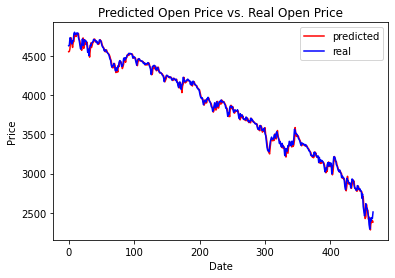

In [9]:

#TODO: separate graph by features 
length = len(predictions)

plt.plot(range(length), [p[0] for p in predictions], color ='r', 
         label ='predicted')
  
plt.plot(range(length), [p[0] for p in real_output], color ='b', 
         label ='real')
  
# naming of x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Price')
  
# naming the title of the plot
plt.title('Predicted Open Price vs. Real Open Price')
  
plt.legend()
plt.show()